# Fundamentals of Finite Volume for TDEM Simulations

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

```{admonition} Prerequisite Tutorials
:class: note
[1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb)
```

**Author:** Devin C. Cowan

</br>

**Keywords:** fundamentals, TDEM, forward simulation, time discretization, mesh discretization.

</br>

**Summary:** Successful forward simulation of TDEM data using mimetic finite volume requires reasonable values for a multitude of input parameters. Most important are the parameters which determine how our numerical scheme is discretized in space and in time. When setting up the TDEM simulation, we aim to find an optimum balance between:

* numerical accuracy, and
* computational resources (e.g. run-time, memory)

In this tutorial, we do not focus on the syntax for generating and using SimPEG objects. We assume the user has worked through the [1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb) tutorial and understands how SimPEG objects are generated and used in TDEM forward simulations.

Here, we demonstrate how discretization in space and in time impacts TDEM forward simulations. Results are then used to develop guidelines that can be applied in almost all cases. To limit the computation time required to run the tutorial, all simulations are performed on a [Cylindrical Mesh](myst:discretize#discretize.CylindricalMesh). However, the knowledge gained here can be applied regardless of the mesh type (e.g. [Tensor Mesh](myst:discretize#discretize.TensorMesh), [Tree Mesh](myst:discretize#discretize.TreeMesh)).

</br>

**Learning Objectives:**

- Using observation times and subsurface conductivity to generate an appropriate mesh.
- Defining the time discretization for step excitation.
- Defining the time discretization during a waveform's on-time.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to TDEM is imported from [SimPEG.electromagnetics.time_domain](myst:SimPEG#SimPEG.electromagnetics.time_domain). Analytic solutions for simplified problem geometry are imported from the [geoana.em.tdem](myst:geoana#geoana.em.tdem) module. We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils).

In [1]:
# SimPEG functionality
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps

# discretize functionality
from discretize import CylindricalMesh, TensorMesh
from discretize.utils import mkvc

# geoana functionality
from geoana.em.tdem import (
    vertical_magnetic_flux_horizontal_loop,
    vertical_magnetic_flux_time_deriv_horizontal_loop
)

# Common Python functionality
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({"font.size": 14})

## Defining the Simulation Geometry

Here, we define the problem geometry that will be used throughout the tutorial. The problem geometry consists of a horizontal circular transmitter loop with a radius of 25 m, located on the Earth's surface. Data are simulated at the center of the loop at a set of logarithmically-spaced time channels. The subsurface electrical conductivity is characterized by a 1e-2 S/m halfspace.

In [2]:
# Source properties
source_location = np.array([0.0, 0.0, 0.0])  # (3, ) numpy.array_like
source_orientation = "z"                     # "x", "y" or "z"
source_current = 1.0                         # maximum on-time current (A)
source_radius = 25.0                         # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 0.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"                      # "x", "y" or "z"
time_channels = np.logspace(-5, -3, 21)         # time channels (s)

# Model properties
air_conductivity = 1e-8
halfspace_conductivity = 1e-2

## Defining Some Tutorial Functions

Here, we define several functions that will be used to quickly generate useful objects throughout the tutorial.

### Generate the Survey

For the waveform object provided, this function generates the survey object for our problem geometry when called.

In [3]:
def generate_survey(waveform_object):
    
    # Define receiver
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_locations, time_channels, orientation=receiver_orientation
        )
    ]
    
    # Define loop source
    source_list = [
        tdem.sources.CircularLoop(
            receiver_list=receiver_list,
            location=source_location,
            waveform=waveform_object,
            current=source_current,
            radius=source_radius,
        )
    ]
    
    return tdem.Survey(source_list)

### Generate the Mesh, Model and Mapping

For the minimum cell size *dh*, minimum diffusion distance *d_min* and maximum diffusion distance *d_max*, this function generates a [Cylindrical Mesh](myst:discretize#discretize.CylindricalMesh).

In [4]:
def generate_discretization(dh, d_min, d_max):
    
    # Number of core mesh cells
    n_core = np.floor(8 * d_min / dh)
    
    # Number of padding cells
    n_pad = 1
    while sum(dh * 1.5**np.arange(n_pad)) < 2 * d_max:
        n_pad += 1
    
    # Radial and vertical discretization
    hr = [(dh, n_core), (dh, n_pad, 1.2)]
    hz = [(dh, n_pad, -1.2), (dh, 2*n_core), (dh, n_pad, 1.2)]
    
    # Generate mesh
    mesh = CylindricalMesh([hr, 1, hz], x0="00C")
    
    # Active cells
    active_cells = mesh.cell_centers[:, -1] < 0.
    
    # Halfspace conductivity model
    model = halfspace_conductivity * np.ones(np.sum(active_cells))
    
    # Mapping from conductivity model to mesh
    mapping = maps.InjectActiveCells(mesh, active_cells, air_conductivity)
    
    return mesh, model, mapping

## Part 1: Discretization in Space (cell size)





$$
d \approx 1260 \sqrt{\frac{t}{\sigma}}
$$

### Compute the Diffusion Distances

In [5]:
diffusion_distances = 1260 * np.sqrt(time_channels / halfspace_conductivity)
d_min = diffusion_distances.min()
d_max = diffusion_distances.max()
print('DIFFUSION DISTANCES: {}'.format(np.round(diffusion_distances, 1)))

DIFFUSION DISTANCES: [ 39.8  44.7  50.2  56.3  63.1  70.9  79.5  89.2 100.1 112.3 126.  141.4
 158.6 178.  199.7 224.1 251.4 282.1 316.5 355.1 398.4]


### Define Minimum Cell Widths

In [6]:
size_factor = [4., 2., 1., 0.5, 0.25]
dh_min = [c * d_min for c in size_factor]

### Define the Waveform

In [7]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

### Simulate the Data

In [8]:
dpred_1 = []

for dh in dh_min:
    
    # Generate mesh, model and mapping
    mesh, model, mapping = generate_discretization(dh, d_min, d_max)
    
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
        time_steps=[(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)]
    )
    
    print('N_CELLS: {}'.format(mesh.nC))
    
    dpred_1.append(simulation.dpred(model))

N_CELLS: 72
N_CELLS: 162
N_CELLS: 392
N_CELLS: 1152
N_CELLS: 3528


### Plot Results and Discuss

In [9]:
dtrue = vertical_magnetic_flux_time_deriv_horizontal_loop(
    time_channels,
    sigma=halfspace_conductivity,
    radius=source_radius,
    current=source_current
)

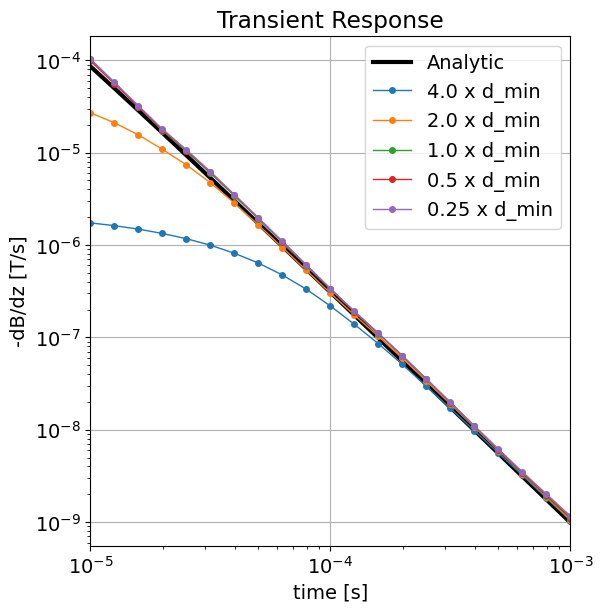

In [10]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
ax1.loglog(time_channels, -dtrue, 'k', lw=3)
for d in dpred_1:
    ax1.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Transient Response")
ax1.legend(['Analytic'] + ['{} x d_min'.format(c) for c in size_factor])
plt.show()

## Part 2: Time-Discretization (off-time)



In [11]:
size_factor = [2.5, 5., 10., 20., 40.]
dt_min = [time_channels.min()/c for c in size_factor]
t_int = [1.1e-5, 1.01e-4, 1.01e-3]

In [12]:
dpred_2 = []
sim_times = []

mesh, model, mapping = generate_discretization(d_min, d_min, d_max)

for dt in dt_min:
    
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
    )
    
    time_steps = [
        (dt, int(t_int[0]/dt)),
        (6*dt, int(t_int[1]/(6*dt))),
        (36*dt, int(t_int[2]/(36*dt)))
    ]
    
    simulation.time_steps = time_steps
    sim_times.append(simulation.times[1:])
    
    print('N_TIMES: {}'.format(simulation.nT))
    
    dpred_2.append(simulation.dpred(model))

N_TIMES: 13
N_TIMES: 27
N_TIMES: 54
N_TIMES: 110
N_TIMES: 222


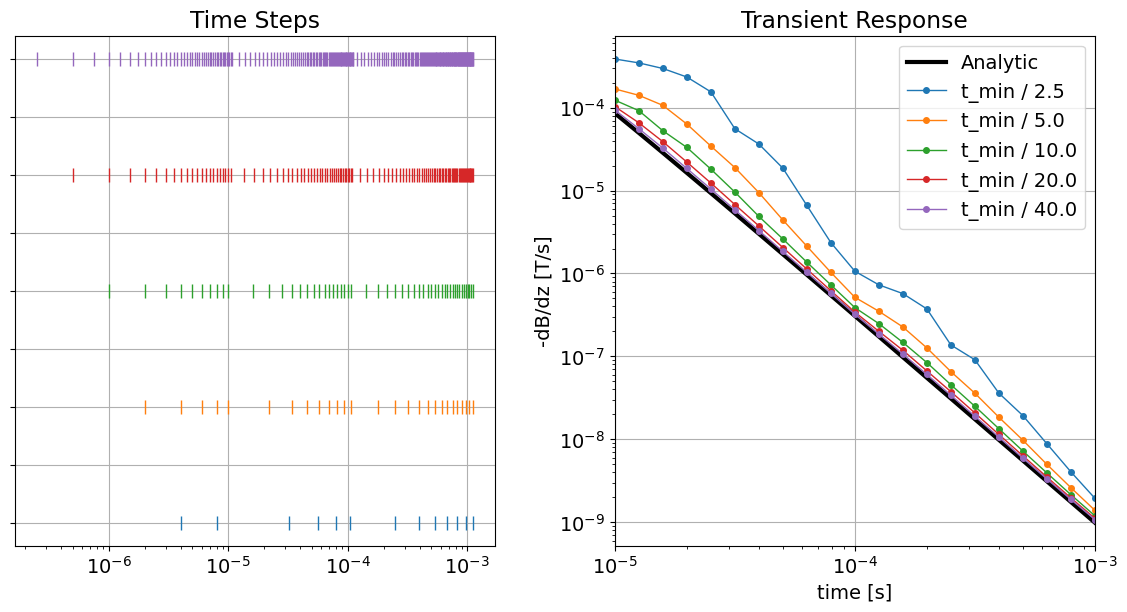

In [13]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
for ii, tvec in enumerate(sim_times):
    ax1.semilogx(tvec, ii*np.ones_like(tvec), '|', markersize=10)
ax1.set_yticklabels([])
ax1.set_title('Time Steps')
ax1.grid()

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.loglog(time_channels, -dtrue, 'k', lw=3)
for d in dpred_2:
    ax2.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax2.set_xlim((np.min(time_channels), np.max(time_channels)))
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("-dB/dz [T/s]")
ax2.set_title("Transient Response")
ax2.legend(['Analytic'] + ['t_min / {}'.format(c) for c in size_factor])
plt.show()

## Part 3: Time-Discretization (on-time)

In [58]:
t0 = -1e-3
n_on_time_steps = [10, 20, 40, 80, 160]
on_time_steps_list = [(np.abs(t0)/n, n) for n in n_on_time_steps]

In [59]:
triangular_waveform = tdem.sources.TriangularWaveform(
    start_time=t0, peak_time=t0/2, off_time=0.0
)

In [60]:
exponential_waveform = tdem.sources.ExponentialWaveform(
    start_time=t0, peak_time=t0/40
)

Waveforms

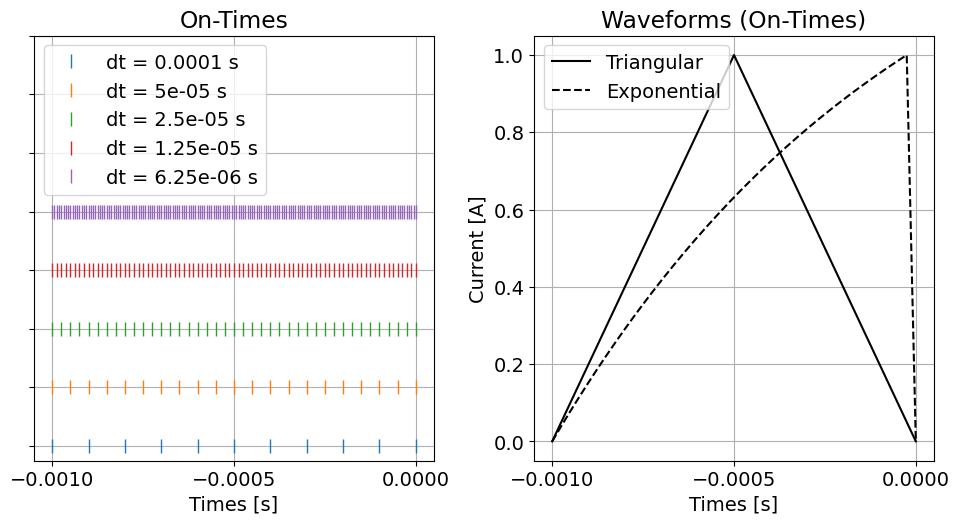

In [75]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
for ii in range(len(on_time_steps_list)):
    t_mesh = TensorMesh([[on_time_steps_list[ii]]], origin=np.array([t0]))
    ax1.plot(t_mesh.nodes_x, ii*np.ones_like(t_mesh.nodes_x), '|', markersize=10)

ax1.set_xticks([-1e-3, -5e-4, 0])
ax1.set_ylim([-0.25, 7])
ax1.set_yticklabels([])
ax1.set_xlabel('Times [s]')
ax1.set_title('On-Times')
ax1.legend(['dt = {} s'.format(x[0]) for x in on_time_steps_list], loc='upper left')
ax1.grid()

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.plot(t_mesh.nodes_x, [triangular_waveform.eval(t) for t in t_mesh.nodes_x], 'k-')
ax2.plot(t_mesh.nodes_x, [exponential_waveform.eval(t) for t in t_mesh.nodes_x], 'k--')
ax2.set_xticks([-1e-3, -5e-4, 0])
ax2.set_xlabel('Times [s]')
ax2.set_ylabel('Current [A]')
ax2.set_title('Waveforms (On-Times)')
ax2.grid()
ax2.legend(['Triangular', 'Exponential'], loc='upper left')

plt.show()

Mesh, model and mapping.

In [62]:
off_time_steps = [(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)]

In [63]:
mesh, model, mapping = generate_discretization(d_min, d_min, d_max)

Triangular waveform.

In [64]:
simulation_temp = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(triangular_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1)
)

In [65]:
dpred_triangular = [simulation_temp.dpred(np.array([halfspace_conductivity]))]

for w in on_time_steps_list:
    
    full_time_steps = [w] + off_time_steps
    
    simulation_temp = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(triangular_waveform),
        sigmaMap=mapping,
        time_steps=full_time_steps,
        t0=t0
    )
    
    dpred_triangular.append(simulation_temp.dpred(model))

Square pulse

In [66]:
simulation_temp = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(exponential_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1)
)

In [67]:
dpred_exponential = [simulation_temp.dpred(np.array([halfspace_conductivity]))]

for w in on_time_steps_list:
    
    full_time_steps = [w] + off_time_steps
    
    simulation_temp = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(exponential_waveform),
        sigmaMap=mapping,
        time_steps=full_time_steps,
        t0=t0
    )
    
    dpred_exponential.append(simulation_temp.dpred(model))

Plot

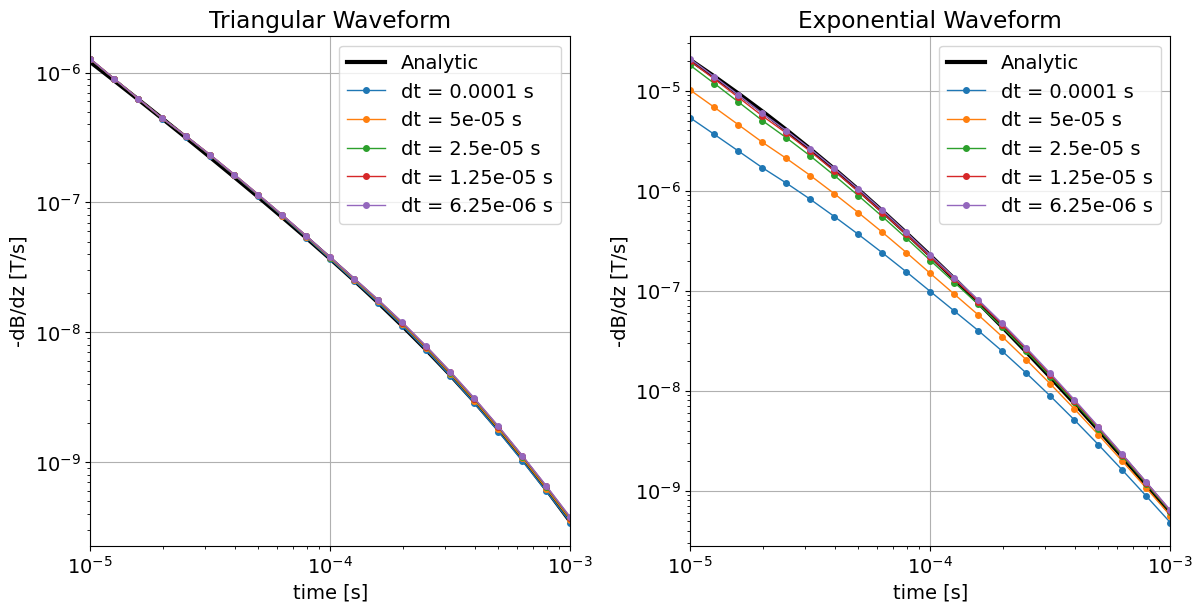

In [68]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
ax1.loglog(time_channels, -dpred_triangular[0], 'k', lw=3)
for d in dpred_triangular[1:]:
    ax1.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Triangular Waveform")
ax1.legend(
    ['Analytic'] + ['dt = {} s'.format(x[0]) for x in on_time_steps_list],
    loc='upper right'
)

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.loglog(time_channels, -dpred_exponential[0], 'k', lw=3)
for d in dpred_exponential[1:]:
    ax2.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax2.set_xlim((np.min(time_channels), np.max(time_channels)))
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("-dB/dz [T/s]")
ax2.set_title("Exponential Waveform")
ax2.legend(
    ['Analytic'] + ['dt = {} s'.format(x[0]) for x in on_time_steps_list],
    loc='upper right'
)

plt.show()